In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize

In [174]:
from collections import namedtuple
from collections import defaultdict

Dataset = namedtuple('Dataset', 'name, train, test')
Model = namedtuple('Model', 'type, name, dimension, corpus, model')

In [597]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)
MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Dev']
columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]


datasets = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

feature_categories = []

def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    return df

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

In [175]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'

glove_defs = [#Model('glove', 'glove.42B.300d.txt', 300, 'cc42B', None),  
              #Model('glove', 'glove.840B.300d.txt', 300, 'cc840B', None), 
              Model('glove', 'glove.6B.50d.txt', 50, 'wikipedia+gigaword5', None), 
              #Model('glove', 'glove.6B.100d.txt',100, 'wikipedia+gigaword5', None),
              #Model('glove', 'glove.6B.200d.txt', 200, 'wikipedia+gigaword5', None), 
              #Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None),
              #Model('glove', 'glove.twitter.27B.25d.txt', 25, 'twitter', None)]
              Model('glove', 'glove.twitter.27B.50d.txt', 50, 'twitter', None)] 
              #Model('glove', 'glove.twitter.27B.100d.txt', 100, 'twitter', None), 
              #Model('glove', 'glove.twitter.27B.200d.txt', 200, 'twitter', None)]

glove_models = []
for model in glove_defs:
    glove_file = datapath(MAIN_PATH + model.name)
    tmp_file = get_tmpfile(model.name + '-temp')
    glove2word2vec(glove_file, tmp_file)
    vecs = KeyedVectors.load_word2vec_format(tmp_file)
    glove_models.append(Model(model.type, model.name, model.dimension, model.corpus, vecs))
    print('load model : {}'.format(model.name))
    
print(glove_models)

load model : glove.6B.50d.txt
load model : glove.twitter.27B.50d.txt
[Model(type='glove', name='glove.6B.50d.txt', dimension=50, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x0000002939FB3F28>), Model(type='glove', name='glove.twitter.27B.50d.txt', dimension=50, corpus='twitter', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x0000002948DE1A58>)]


In [80]:
dataframe = datasets[0].train[0:30]

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def extract_ngrams_group(group):
    targets = zip(group['target'].values.tolist(), group['start'].values.tolist()
                 group['end'].values.tolist(), group['binary'].values.tolist())
    for word, start, end, binary in targets:
        tokens = word.split()
        if len(tokens)>1:
            olap_words = [(w, b) for w, s, e, b in targets if overlaps(start, end, s, e)]
            
    
grouped = dataframe.groupby('sentence').apply(lambda group : extract_ngrams_group(group))

In [565]:
from nltk import word_tokenize
from functools import lru_cache
from utils import penn_to_wn
import re
import unicodedata
import sys
from collections import Counter
# Note that this startegy ignores the embedding value ranges
from ngram_representation import missing_strat_random

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def all_tokens_with_index(context):
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    return [val for val in targets if val[0] != '"']

def build_vocabulary(sentences, embedding_model, dimension):
    all_words = [tpl[0] for sentence in sentences for tpl in sentence['seq']]
    print('# Words : {}'.format(len(all_words)))
    counter = Counter(all_words)
    vocab_size = len(counter) + 1
    print('# Vocab : {}'.format(vocab_size))
    word2index = {word : index for index, (word, count) in enumerate(counter.most_common(), 1)}
    index2word = {index : word for word, index in word2index.items()}
    # +1 required for pad token
    embedding_matrix = np.zeros(((vocab_size), dimension))
    embedding_matrix[0] = missing_strat_random('pad', dimension)
    missing_embed_words = []
    for word, index in word2index.items():
        if word in embedding_model.vocab:
            embedding = embedding_model[word]
        else:
            embedding = missing_strat_random(word, dimension)
            missing_embed_words.append(word)
        embedding_matrix[index] = embedding
    missing_embed_count = len(missing_embed_words)
    print('# Words missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    return word2index, index2word, embedding_matrix

def forward_transformation(dataframe, lowercase = True, filter_punc = True, filtering = "a132"):
    grouped = dataframe.groupby('sentence').apply(lambda row : 
                        {'sent_id' : list(set(row['sent_id']))[0],
                         'sentence' : list(set(row['sentence']))[0], 
                         'tags': [tag for tag in zip(row['target'], 
                            row['start'], row['end'], row['binary'], row['prob'])]})
    sentences = []
    for vals in grouped:
        sent_id = vals['sent_id']
        sentence = vals['sentence']
        tags = vals['tags']
        tags_without_labels = [(word, start, end) for word, start, end, binary, prob in tags]
        all_tokens = all_tokens_with_index(sentence)
        sent_repr = [(word, start, end, tags[tags_without_labels.index((word, start, end))][3],
                     tags[tags_without_labels.index((word, start, end))][4])
           if (word, start, end) in tags_without_labels 
          else (word, start, end, 0, 0.0) for word, index, start, end in all_tokens]
        if lowercase:
            sent_repr = [(word.lower(), start, end, binary, prob) 
                         for word, start, end, binary, prob in sent_repr]
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentences.append({'sent_id' : sent_id, 'sentence' : sentence, 'seq' : sent_repr})
    return sentences

def split_sentence_seqs(sentences):
    words, start_end, binary, prob = [], [], [] ,[]
    for sent in sentences:
        sequence = sent['seq']
        curr_w, curr_se, curr_b, curr_p = map(list, zip(*[(vals[0], 
            (vals[1], vals[2]), vals[3], vals[4]) for vals in sequence]))
        words.append(curr_w)
        start_end.append(curr_se)
        binary.append(curr_b)
        prob.append(curr_p)
    return words, start_end, binary, prob

In [598]:
# Append train and test set
dataset_sel = datasets[0]
train_num_rows = dataset_sel.train.shape[0]
train_num_sents = len(list(set(dataset_sel.train.sentence.values.tolist())))

test_num_rows = dataset_sel.test.shape[0]
test_num_sents = len(list(set(dataset_sel.test.sentence.values.tolist())))

dataset = dataset_sel.train.append(dataset_sel.test)
dataset['sent_id'] = dataset.groupby('sentence').ngroup()
dataset_num_rows = dataset.shape[0]
dataset_num_sents = len(list(set(dataset.sentence.values.tolist())))

print('# Rows train : {}'.format(train_num_rows))
print('# Rows test : {}'.format(test_num_rows))
print('# Rows dataset : {}'.format(dataset_num_rows))

print('# Sents train : {}'.format(train_num_sents))
print('# Sents test : {}'.format(test_num_sents))
print('# Sents dataset : {}'.format(dataset_num_sents))

# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
# Sents train : 387
# Sents test : 53
# Sents dataset : 440


In [603]:
sentences = forward_transformation(dataset)
train_sentences = sentences[:train_num_sents]
test_sentences = sentences[train_num_sents:]

In [ ]:
sentences[10]

In [604]:
words, start_end, binary, prob = split_sentence_seqs(sentences)

In [605]:
sentence_lens = [len(sent) for sent in words]

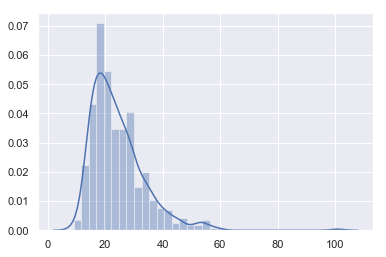

In [606]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set()
ax = sns.distplot(sentence_lens)
plt.show()

In [453]:
figure = ax.get_figure()
figure.savefig('../plots/dl/sentence_length_dist.pdf')

In [607]:
embedding_model = models[0].model
dimension = embedding_model.vector_size
word2index, index2word, embedding = build_vocabulary(sentences, embedding_model, dimension)

# Words : 10722
# Vocab : 3639
# Words missing embedding : 159
Embedding shape : (3639, 50)


In [608]:
words_with_indices = [[word2index[word] for word in sent] for sent in words]

In [609]:
sent_lens = [len(sentence['seq']) for sentence in sentences]
sent_max_length = np.max(sent_lens)
print('Max length sentence : {}'.format(sent_max_length))

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

words_padded = pad_sequences(maxlen=sent_max_length, sequences=words_with_indices, padding="post", value=0)
binary_padded = pad_sequences(maxlen=sent_max_length, sequences=binary, padding="post", value=0)
prob_padded = pad_sequences(maxlen=sent_max_length, sequences=prob, padding="post", value=0, dtype="float")

binary_padded_categorical = [to_categorical(clazz, num_classes=2) for clazz in binary_padded]

Max length sentence : 101


In [610]:
# Split the previously combined train and test set

# (1) Training set
train_words_padded = words_padded[:train_num_sents]
train_binary_padded = binary_padded[:train_num_sents]
train_binary_padded_categorical = binary_padded_categorical[:train_num_sents]
train_prob_padded = prob_padded[:train_num_sents]
train_start_end = start_end[:train_num_sents]

# (2) Test set
test_words_padded = words_padded[train_num_sents:]
test_binary_padded = binary_padded[train_num_sents:]
test_binary_padded_categorical = binary_padded_categorical[train_num_sents:]
test_prob_padded = prob_padded[train_num_sents:]
test_start_end = start_end[train_num_sents:]

print('Training set length : {}'.format(len(train_words_padded)))
print('Test set length : {}'.format(len(test_words_padded)))

Training set length : 387
Test set length : 53


In [611]:
from sklearn.metrics import f1_score
import keras.callbacks

class Metrics(keras.callbacks.Callback):
    def __init__(self):
        self.f1_scores = []
        
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = self.validation_data[1]
        targ = np.array(targ)
        shape = targ.shape
        targ = targ.reshape((shape[0]*shape[1], shape[2]))
        targ = np.argmax(targ, axis = 1)
        predict = predict.reshape((shape[0]*shape[1]), shape[2])
        predict = np.argmax(predict, axis = 1)
        self.f1s=f1_score(targ, predict)
        print(f1_score(targ, np.ones(shape[0]*shape[1])))
        print('--------------------Targets-------------------------')
        print(self.f1s)
        self.f1_scores.append(self.f1s)
        print(targ)
        print('--------------------Predictions-------------------------')
        print(predict)
        return

In [612]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

vocab_size = embedding.shape[0]
dimension = embedding.shape[1]

np.set_printoptions(threshold=np.inf)

in_seq = Input(shape=(sent_max_length,))
embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
drop = Dropout(0.1)(embed)
lstm = Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.1))(drop)
out = TimeDistributed(Dense(2, activation="softmax"))(lstm) 

model = Model(in_seq, out)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

metrics = Metrics()
history = model.fit(train_words_padded, np.array(train_binary_padded_categorical), batch_size=8, 
                    epochs=30, validation_data = (test_words_padded, np.array(test_binary_padded_categorical)), 
                    verbose=1, callbacks=[metrics])

Train on 387 samples, validate on 53 samples
Epoch 1/30


In [710]:
len(metrics.f1_scores)

60

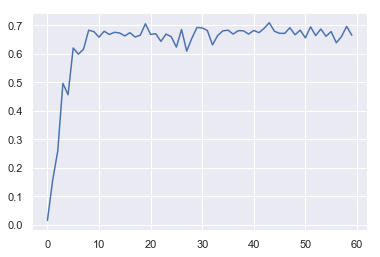

In [711]:
sns.set_style("darkgrid")
epoch_f1s = plt.plot(metrics.f1_scores)
plt.show()

In [712]:
predictions = model.predict(test_words_padded)
predictions.shape

(53, 101, 2)

In [713]:
final_predictions = np.argmax(predictions, axis = 2)

In [714]:
final_predictions

array([[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0,

In [588]:
test_binary_padded

array([[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0,

In [593]:
dataset.loc[dataset.sent_id==344,]

,id,sentence,start,end,target,nat,non_nat,nat_marked,non_nat_marked,binary,prob,sent_id
5483,3ZUE82NE0A2B8701X4995O8OCRS8FL,"There are several generations of Acherontia atropos per year , with continuous broods in Africa .",18,29,generations,10,10,1,3,1,0.20,344
5484,3ZUE82NE0A2B8701X4995O8OCRS8FL,"There are several generations of Acherontia atropos per year , with continuous broods in Africa .",33,43,Acherontia,10,10,1,0,1,0.05,344
5485,3ZUE82NE0A2B8701X4995O8OCRS8FL,"There are several generations of Acherontia atropos per year , with continuous broods in Africa .",33,51,Acherontia atropos,10,10,4,2,1,0.30,344
5486,3ZUE82NE0A2B8701X4995O8OCRS8FL,"There are several generations of Acherontia atropos per year , with continuous broods in Africa .",44,51,atropos,10,10,4,3,1,0.35,344
5487,3ZUE82NE0A2B8701X4995O8OCRS8FL,"There are several generations of Acherontia atropos per year , with continuous broods in Africa .",68,78,continuous,10,10,2,2,1,0.20,344
5488,3ZUE82NE0A2B8701X4995O8OCRS8FL,"There are several generations of Acherontia atropos per year , with continuous broods in Africa .",56,60,year,10,10,0,0,0,0.00,344
5489,3ZUE82NE0A2B8701X4995O8OCRS8FL,"There are several generations of Acherontia atropos per year , with continuous broods in Africa .",68,85,continuous broods,10,10,1,1,1,0.10,344
5490,3ZUE82NE0A2B8701X4995O8OCRS8FL,"There are several generations of Acherontia atropos per year , with continuous broods in Africa .",79,85,broods,10,10,5,9,1,0.70,344
5491,3ZUE82NE0A2B8701X4995O8OCRS8FL,"There are several generations of Acherontia atropos per year , with continuous broods in Africa .",89,95,Africa,10,10,0,0,0,0.00,344


In [715]:
def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def ngram_prediction_agg_majority_vote(predictions):
    positive_sum = np.sum(predictions)
    ratio = positive_sum / len(predictions)
    return int(ratio + 0.5)

def ngram_prediction_agg_max(predictions):
    return np.max(predictions)

def ngram_prediction_agg_begin(predictions):
    return predictions[0]

def ngram_prediction_agg_end(predictions):
    return predictions[-1]

ngram_prediction_agg = ngram_prediction_agg_max
results = []
dataframe = dataset
num_missing_match = []
all_predictions = []
all_labels = []
count=0
sent_count = 0
for ind, sent in enumerate(test_words_padded):
    sentence = test_sentences[ind]['sentence']
    sent_id = test_sentences[ind]['sent_id']
    words = [index2word.get(index, 'pad')  for index in sent]
    print(sentence)
    print(sent_id)
    print(words)
    ses = test_start_end[ind]
    preds = final_predictions[ind]
    print(ses)
    print(preds)
    selected = dataframe.loc[dataframe.sent_id==sent_id,]
    targets = selected.target.values.tolist()
    start_ends = list(zip(selected.start.values.tolist(), selected.end.values.tolist()))
    binary_y = selected.binary.values.tolist()
    print(binary_y)
    print(targets)
    print(start_ends)
    for label_index,(start, end) in enumerate(start_ends):
        print('-----',start, end)
        matching_indices = [i for i, (s, e) in enumerate(ses) if overlaps(start, end, s, e)]
        if not matching_indices:
            num_missing_match.append((sentence, sent_id, (start,end), ses, words))
            prediction = 0
        matching_predictions = [preds[i] for i in matching_indices]
        if len(matching_predictions)>1:
            prediction = ngram_prediction_agg(matching_predictions)
        else:
            if matching_indices:
                prediction = matching_predictions[0]
        matching_labels = binary_y[label_index]
        print(matching_indices)
        print(matching_labels)
        print(matching_predictions)
        print(prediction)
        all_labels.append(matching_labels)
        all_predictions.append(prediction)


The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .
387
['the', 'zero', 'point', 'of', 'any', 'thermodynamic', 'temperature', 'scale', 'such', 'as', 'kelvin', 'or', 'rankine', 'is', 'set', 'at', 'absolute', 'zero', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad']
[(0, 3), (4, 8), (9, 14), (15, 17), (18, 21), (22, 35), (36, 47), (48, 53), (56, 60), (61, 63), (64, 70), (71, 73), (74, 81), (84, 86), (87, 90), 

----- 43 56
[7]
1
[1]
1
----- 6 14
[1]
0
[1]
1
----- 22 29
[3]
0
[1]
1
----- 34 39
[5]
0
[0]
0
----- 93 101
[15]
1
[1]
1
----- 73 77
[12]
0
[0]
0
----- 78 83
[13]
0
[0]
0
----- 93 116
[15, 16, 17]
1
[1, 0, 1]
1
----- 106 116
[17]
1
[1]
1
----- 131 153
[20, 21, 22]
1
[0, 1, 0]
1
----- 131 139
[20, 21]
0
[0, 1]
1
----- 140 153
[21, 22]
1
[1, 0]
1
----- 154 162
[22, 23, 24]
1
[0, 0, 0]
0
----- 172 180
[]
1
[]
0
These mountain chains are separated from each other by several tributaries of the Rhine : the Mosel , the Lahn , and the Nahe .
396
['these', 'mountain', 'chains', 'are', 'separated', 'from', 'each', 'other', 'by', 'several', 'tributaries', 'of', 'the', 'rhine', 'the', 'mosel', 'the', 'lahn', 'and', 'the', 'nahe', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad',

----- 22 29
[4]
1
[1]
1
----- 0 4
[0]
0
[0]
0
----- 5 10
[1]
0
[0]
0
----- 11 15
[2]
0
[0]
0
----- 55 58
[10]
1
[1]
1
----- 61 68
[11]
1
[1]
1
----- 69 81
[12, 13]
1
[0, 1]
1
----- 69 74
[12]
0
[0]
0
----- 96 107
[16]
1
[0]
0
----- 75 81
[13]
0
[1]
1
----- 132 144
[20]
1
[1]
1
----- 115 127
[18]
0
[1]
1
----- 145 152
[21]
0
[0]
0
----- 156 160
[23]
0
[0]
0
----- 161 166
[24]
0
[0]
0
Two also has the unique property such that and also for a not equal to zero The number of domino tilings of a 2 × 2 checkerboard is 2 .
414
['two', 'also', 'has', 'the', 'unique', 'property', 'such', 'that', 'and', 'also', 'for', 'a', 'not', 'equal', 'to', 'zero', 'the', 'number', 'of', 'domino', 'tilings', 'of', 'a', '2', '×', '2', 'checkerboard', 'is', '2', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 

----- 43 47
[8]
0
[0]
0
----- 61 67
[12]
0
[0]
0
----- 136 144
[26]
1
[1]
1
----- 88 96
[17]
0
[1]
1
----- 108 113
[20]
0
[1]
1
----- 114 120
[21]
0
[1]
1
While it is possible to request a change in username , this takes a little longer and requires that a user with bureaucrat access do so .
432
['while', 'it', 'is', 'possible', 'to', 'request', 'a', 'change', 'in', 'username', 'this', 'takes', 'a', 'little', 'longer', 'and', 'requires', 'that', 'a', 'user', 'with', 'bureaucrat', 'access', 'do', 'so', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pad', 'pa

In [716]:
f1_score(all_labels, all_predictions)

0.6777609682299546

In [691]:
len(all_labels)


707

In [637]:
dataset.loc[dataset.sent_id==387,]

,id,sentence,start,end,target,nat,non_nat,nat_marked,non_nat_marked,binary,prob,sent_id
226,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",4,14,zero point,10,10,1,0,1,0.05,387
227,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",22,35,thermodynamic,10,10,2,2,1,0.20,387
228,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",9,14,point,10,10,0,0,0,0.00,387
229,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",36,47,temperature,10,10,2,0,1,0.10,387
230,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",36,53,temperature scale,10,10,1,0,1,0.05,387
231,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",48,53,scale,10,10,1,1,1,0.10,387
232,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",64,70,Kelvin,10,10,2,0,1,0.10,387
233,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",74,81,Rankine,10,10,2,0,1,0.10,387
234,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",94,102,absolute,10,10,0,0,0,0.00,387
235,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",87,90,set,10,10,0,0,0,0.00,387
